In [1]:
import json

In [2]:
raw_file_name = "../datasets/plans/raw/workload_100k_s1_c8220.json"

In [3]:
with open(raw_file_name, "r") as f:
    raw_tcp_normal_data = json.load(f)

In [4]:
queries = raw_tcp_normal_data['query_list']

In [86]:
queries[0]['analyze_plans']

[[['Aggregate  (cost=470058.46..470058.47 rows=1 width=8) (actual time=12196.367..12196.610 rows=1 loops=1)'],
  ['  ->  Hash Join  (cost=420018.89..470055.28 rows=636 width=8) (actual time=6984.563..11945.785 rows=2250782 loops=1)'],
  ['        Hash Cond: (orders.o_orderkey = lineitem.l_orderkey)'],
  ['        ->  Seq Scan on orders  (cost=0.00..44845.00 rows=1382674 width=12) (actual time=0.036..494.915 rows=1383339 loops=1)'],
  ['              Filter: (o_custkey >= 11703)'],
  ['              Rows Removed by Filter: 116661'],
  ['        ->  Hash  (cost=420010.26..420010.26 rows=690 width=4) (actual time=6983.972..6984.210 rows=2440072 loops=1)'],
  ['              Buckets: 131072 (originally 1024)  Batches: 32 (originally 1)  Memory Usage: 3722kB'],
  ['              ->  Gather  (cost=406476.64..420010.26 rows=690 width=4) (actual time=3002.756..5572.096 rows=2440072 loops=1)'],
  ['                    Workers Planned: 2'],
  ['                    Workers Launched: 2'],
  ['    

In [91]:
count = 0
for query in queries:
  if query['analyze_plans'] != []:
    runtime = float(re.search(r'(\d+\.\d+)\s*ms', query['analyze_plans'][0][-1][0]).group(1))
    if runtime < 10 or runtime > 30000:
      count += 1

print(count)

2951


In [78]:
len(raw_tcp_normal_data)
# for key in raw_tcp_normal_data:
#   print(key)

for key in raw_tcp_normal_data['database_stats']:
  print(key)

# raw_tcp_normal_data['database_stats']['table_stats']
# raw_tcp_normal_data['database_stats']['column_stats']

# raw_tcp_normal_data['query_list']

column_stats
table_stats


In [73]:
raw_tcp_normal_data['database_stats']['column_stats']

[{'tablename': 'nation',
  'attname': 'n_nationkey',
  'null_frac': 0.0,
  'avg_width': 4,
  'n_distinct': -1.0,
  'correlation': 1.0,
  'data_type': 'integer'},
 {'tablename': 'nation',
  'attname': 'n_name',
  'null_frac': 0.0,
  'avg_width': 26,
  'n_distinct': -1.0,
  'correlation': 0.913077,
  'data_type': 'character'},
 {'tablename': 'nation',
  'attname': 'n_regionkey',
  'null_frac': 0.0,
  'avg_width': 4,
  'n_distinct': -0.2,
  'correlation': 0.347692,
  'data_type': 'integer'},
 {'tablename': 'nation',
  'attname': 'n_comment',
  'null_frac': 0.0,
  'avg_width': 75,
  'n_distinct': -1.0,
  'correlation': 0.0784615,
  'data_type': 'character varying'},
 {'tablename': 'region',
  'attname': 'r_regionkey',
  'null_frac': 0.0,
  'avg_width': 4,
  'n_distinct': -1.0,
  'correlation': 1.0,
  'data_type': 'integer'},
 {'tablename': 'region',
  'attname': 'r_name',
  'null_frac': 0.0,
  'avg_width': 26,
  'n_distinct': -1.0,
  'correlation': 1.0,
  'data_type': 'character'},
 {'tabl

In [5]:
import re

planning_time_regex = re.compile('planning time: (?P<planning_time>\d+.\d+) ms')
ex_time_regex = re.compile('execution time: (?P<execution_time>\d+.\d+) ms')
init_plan_regex = re.compile("InitPlan \d+ \(returns \$\d\)")
join_columns_regex = re.compile('\w+\.\w+ ?= ?\w+\.\w+')


In [45]:
for key in raw_tcp_normal_data['query_list'][0]:
  print(key)

analyze_plans
verbose_plan
sql


In [46]:
type(raw_tcp_normal_data['query_list'][0])

dict

In [29]:
# Cases that left out from parsing raw data statistics

for q in raw_tcp_normal_data['query_list']:

  if q['analyze_plans'] is None:
      continue
  if len(q['analyze_plans']) == 0:
      continue

  analyze_str = ''.join([l[0] for l in q['verbose_plan']])
  if 'SubPlan' in analyze_str or 'InitPlan' in analyze_str:
      print('Subplan in query', q, '\n')
      continue
  
  if '->  Result  (cost=0.00..0.00 rows=0' in analyze_str:
      print('Subplan is empty due to logical constraints in query', q, '\n')
      continue
  
  # check if it just initializes a plan
  if isinstance(q['analyze_plans'][0][0], list):
      analyze_plan_string = ''.join(l[0] for l in q['analyze_plans'][0])
  else:
      analyze_plan_string = ''.join(q['analyze_plans'])
  if init_plan_regex.search(analyze_plan_string) is not None:
      print('Plan is initializing:', q, '\n')
      continue
  

Subplan is empty due to logical constraints in query {'analyze_plans': [[['Aggregate  (cost=0.01..0.01 rows=1 width=72) (actual time=0.007..0.007 rows=1 loops=1)'], ['  ->  Result  (cost=0.00..0.00 rows=0 width=10) (actual time=0.001..0.001 rows=0 loops=1)'], ['        One-Time Filter: false'], ['Planning time: 0.769 ms'], ['Execution time: 0.061 ms']]], 'verbose_plan': [['Aggregate  (cost=0.01..0.01 rows=1 width=72)'], ['  Output: count(*), avg(supplier.s_acctbal), sum((supplier.s_acctbal + (nation.n_regionkey)::numeric))'], ['  ->  Result  (cost=0.00..0.00 rows=0 width=10)'], ['        Output: supplier.s_acctbal, nation.n_regionkey'], ['        One-Time Filter: false']], 'sql': 'SELECT COUNT(*), AVG("supplier"."s_acctbal"), SUM("supplier"."s_acctbal" + "nation"."n_regionkey") FROM "region" JOIN "nation" ON "region"."r_regionkey" = "nation"."n_regionkey" JOIN "supplier" ON "nation"."n_nationkey" = "supplier"."s_nationkey"  WHERE "supplier"."s_address" = \',6RXmcRyA48c0yvZ2I\' AND "nat

In [47]:
for key in raw_tcp_normal_data:
  print(key)

query_list
database_stats
run_kwargs
total_time_secs


In [106]:
with open('../plain_statement_5000.json', 'r') as json_file:
    dataset = json.load(json_file)

X = [entry['sql'] for entry in dataset]
for x in X[:20]:
  print(x)

SELECT SUM("orders"."o_custkey" + "orders"."o_shippriority") FROM "lineitem" JOIN "partsupp" ON "lineitem"."l_partkey" = "partsupp"."ps_partkey" AND "lineitem"."l_suppkey" = "partsupp"."ps_suppkey" JOIN "supplier" ON "partsupp"."ps_suppkey" = "supplier"."s_suppkey" JOIN "part" ON "partsupp"."ps_partkey" = "part"."p_partkey" JOIN "orders" ON "lineitem"."l_orderkey" = "orders"."o_orderkey" JOIN "nation" ON "supplier"."s_nationkey" = "nation"."n_nationkey"  WHERE "part"."p_partkey" >= 113704 AND "partsupp"."ps_partkey" >= 58279 AND "partsupp"."ps_suppkey" <= 9430 AND "orders"."o_custkey" >= 11703;
SELECT COUNT(*), SUM("lineitem"."l_linenumber" + "lineitem"."l_tax") FROM "lineitem"  WHERE "lineitem"."l_linestatus" = 'F' AND "lineitem"."l_quantity" != 35 AND "lineitem"."l_discount" >= 0.07119490467980717 AND "lineitem"."l_linenumber" = 3;
SELECT COUNT(*) FROM "orders" JOIN "lineitem" ON "orders"."o_orderkey" = "lineitem"."l_orderkey" JOIN "customer" ON "orders"."o_custkey" = "customer"."c_c

In [103]:
count = 0
plantime_list = []

for i in range(len(raw_tcp_normal_data['query_list'])):
  query = raw_tcp_normal_data['query_list'][i]
  
  if not query['analyze_plans'] == []:
    count += 1
    plantime_text = query['analyze_plans'][0][-2][0]
    plantime = float(re.search(r'(\d+\.\d+)\s*ms', plantime_text).group(1))

    plantime_list.append(plantime)


print(sum(plantime_list)/count)
print(max(plantime_list))
print(min(plantime_list))

1.1701780338350851
4.205
0.214


In [97]:
raw_tcp_normal_data['query_list'][0]['verbose_plan']

[['Aggregate  (cost=470058.46..470058.47 rows=1 width=8)'],
 ['  Output: sum((orders.o_custkey + orders.o_shippriority))'],
 ['  ->  Hash Join  (cost=420018.89..470055.28 rows=636 width=8)'],
 ['        Output: orders.o_custkey, orders.o_shippriority'],
 ['        Hash Cond: (orders.o_orderkey = lineitem.l_orderkey)'],
 ['        ->  Seq Scan on public.orders  (cost=0.00..44845.00 rows=1382674 width=12)'],
 ['              Output: orders.o_orderkey, orders.o_custkey, orders.o_orderstatus, orders.o_totalprice, orders.o_orderdate, orders.o_orderpriority, orders.o_clerk, orders.o_shippriority, orders.o_comment'],
 ['              Filter: (orders.o_custkey >= 11703)'],
 ['        ->  Hash  (cost=420010.26..420010.26 rows=690 width=4)'],
 ['              Output: lineitem.l_orderkey'],
 ['              ->  Gather  (cost=406476.64..420010.26 rows=690 width=4)'],
 ['                    Output: lineitem.l_orderkey'],
 ['                    Workers Planned: 2'],
 ['                    ->  Hash J

In [48]:
raw_tcp_normal_data['query_list'][0]['sql']

'SELECT SUM("orders"."o_custkey" + "orders"."o_shippriority") FROM "lineitem" JOIN "partsupp" ON "lineitem"."l_partkey" = "partsupp"."ps_partkey" AND "lineitem"."l_suppkey" = "partsupp"."ps_suppkey" JOIN "supplier" ON "partsupp"."ps_suppkey" = "supplier"."s_suppkey" JOIN "part" ON "partsupp"."ps_partkey" = "part"."p_partkey" JOIN "orders" ON "lineitem"."l_orderkey" = "orders"."o_orderkey" JOIN "nation" ON "supplier"."s_nationkey" = "nation"."n_nationkey"  WHERE "part"."p_partkey" >= 113704 AND "partsupp"."ps_partkey" >= 58279 AND "partsupp"."ps_suppkey" <= 9430 AND "orders"."o_custkey" >= 11703;'

In [47]:
raw_dict = raw_tcp_normal_data['query_list'][0]

In [90]:
count = 0
for i in range(len(raw_tcp_normal_data['query_list'])):
  query = raw_tcp_normal_data['query_list'][i]
  if not query['analyze_plans'] == []:
    runtime_text = query['analyze_plans'][0][-1][0]
    runtime = float(re.search(r'(\d+\.\d+)\s*ms', runtime_text).group(1))

    if runtime >= 100 and runtime <= 300000:
      count += 1
    
    if count == 5000:
      break
print(count)

10687


In [60]:
plain_statemnet_5000 = []
plain_statement = []
runtime_all = []

count = 0
runtime_5000= []

for i in range(len(raw_tcp_normal_data['query_list'])):
  query = raw_tcp_normal_data['query_list'][i]
  sql_text = query['sql']
  # print(i, "\n")
  # print(query['analyze_plans'])
  if not query['analyze_plans'] == []:
    runtime_text = query['analyze_plans'][0][-1][0]
    runtime = float(re.search(r'(\d+\.\d+)\s*ms', runtime_text).group(1))
    # print(sql_text, runtime_text)

    if runtime >= 100 and runtime <= 30000:
      data_entry = {"sql": sql_text, "runtime_ms": runtime}
      # runtime_list.append(runtime)
      plain_statement.append(data_entry)
      runtime_all.append(runtime)

      if count < 5000 and runtime == runtime_parsed[count]:
        runtime_5000.append(runtime)
        plain_statemnet_5000.append(data_entry)
        count += 1
  
# for entry in test_:
#     print(entry)

print(len(plain_statement), len(plain_statemnet_5000))

# print(len(test_))
# with open('../plain_statement.json', 'w') as json_file:
#     json.dump(plain_statement, json_file, indent=4)

# with open('../plain_statement_5000.json', 'w') as json_file:
#     json.dump(plain_statemnet_5000, json_file, indent=4)

10687 5000


In [52]:
with open('../plain_statement_10000.json', 'r') as json_file:
    dataset = json.load(json_file)

X = [entry['sql'] for entry in dataset]
Y = [entry['runtime_ms'] for entry in dataset]

In [53]:
X[1293]

'SELECT COUNT(*) FROM "orders" JOIN "customer" ON "orders"."o_custkey" = "customer"."c_custkey"  WHERE "orders"."o_clerk" = \'Clerk#000000682\' AND "orders"."o_orderdate" != \'1992-07-27\' AND "customer"."c_custkey" >= 120925 AND "customer"."c_nationkey" <= 0;'

In [54]:
with open('../plain_statement_5000.json', 'r') as json_file:
    dataset = json.load(json_file)

x_ = [entry['sql'] for entry in dataset]
y_ = [entry['runtime_ms'] for entry in dataset]

In [55]:
x_[1293]

'SELECT COUNT(*) FROM "orders" JOIN "customer" ON "orders"."o_custkey" = "customer"."c_custkey"  WHERE "orders"."o_clerk" = \'Clerk#000000682\' AND "orders"."o_orderdate" != \'1992-07-27\' AND "customer"."c_custkey" >= 120925 AND "customer"."c_nationkey" <= 0;'

In [63]:
import matplotlib.pyplot as plt

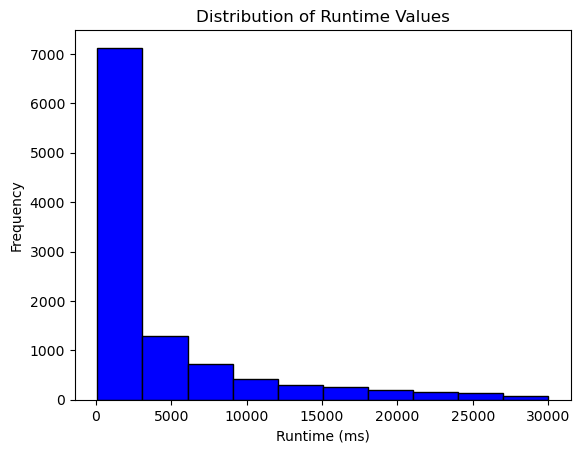

In [64]:
# Create a histogram
plt.hist(runtime_all, bins=10, range=(100, 30000), color='blue', edgecolor='black')

# Set the title and labels
plt.title('Distribution of Runtime Values')
plt.xlabel('Runtime (ms)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [65]:
import numpy as np
# Calculate the histogram
hist_values, bin_edges = np.histogram(runtime_all, bins=10, range=(0, 30000))

# Print the values of each bin
for i in range(len(hist_values)):
    print(f"Bin {i+1}: {hist_values[i]}")

# Print the bin edges
print("Bin Edges:", bin_edges)

Bin 1: 7071
Bin 2: 1325
Bin 3: 725
Bin 4: 430
Bin 5: 311
Bin 6: 253
Bin 7: 204
Bin 8: 156
Bin 9: 141
Bin 10: 71
Bin Edges: [    0.  3000.  6000.  9000. 12000. 15000. 18000. 21000. 24000. 27000.
 30000.]


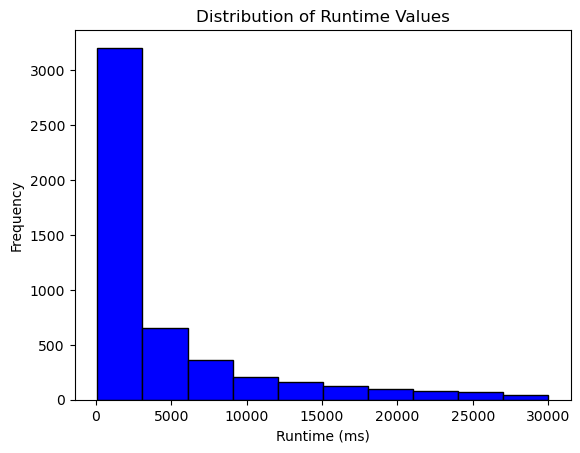

In [66]:
plt.hist(runtime_5000, bins=10, range=(100, 30000), color='blue', edgecolor='black')

# Set the title and labels
plt.title('Distribution of Runtime Values')
plt.xlabel('Runtime (ms)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [ ]:
import numpy as np
# Calculate the histogram
hist_values, bin_edges = np.histogram(runtime_5000, bins=10, range=(0, 30000))

# Print the values of each bin
for i in range(len(hist_values)):
    print(f"Bin {i+1}: {hist_values[i]}")

# Print the bin edges
print("Bin Edges:", bin_edges)

In [116]:
x_[:10]

['SELECT SUM("orders"."o_custkey" + "orders"."o_shippriority") FROM "lineitem" JOIN "partsupp" ON "lineitem"."l_partkey" = "partsupp"."ps_partkey" AND "lineitem"."l_suppkey" = "partsupp"."ps_suppkey" JOIN "supplier" ON "partsupp"."ps_suppkey" = "supplier"."s_suppkey" JOIN "part" ON "partsupp"."ps_partkey" = "part"."p_partkey" JOIN "orders" ON "lineitem"."l_orderkey" = "orders"."o_orderkey" JOIN "nation" ON "supplier"."s_nationkey" = "nation"."n_nationkey"  WHERE "part"."p_partkey" >= 113704 AND "partsupp"."ps_partkey" >= 58279 AND "partsupp"."ps_suppkey" <= 9430 AND "orders"."o_custkey" >= 11703;',
 'SELECT COUNT(*), SUM("lineitem"."l_linenumber" + "lineitem"."l_tax") FROM "lineitem"  WHERE "lineitem"."l_linestatus" = \'F\' AND "lineitem"."l_quantity" != 35 AND "lineitem"."l_discount" >= 0.07119490467980717 AND "lineitem"."l_linenumber" = 3;',
 'SELECT COUNT(*) FROM "orders" JOIN "lineitem" ON "orders"."o_orderkey" = "lineitem"."l_orderkey" JOIN "customer" ON "orders"."o_custkey" = "cu

In [114]:
X[3087]

'SELECT COUNT(*), SUM("customer"."c_custkey") FROM "customer" JOIN "orders" ON "customer"."c_custkey" = "orders"."o_custkey" JOIN "lineitem" ON "orders"."o_orderkey" = "lineitem"."l_orderkey" JOIN "partsupp" ON "lineitem"."l_partkey" = "partsupp"."ps_partkey" AND "lineitem"."l_suppkey" = "partsupp"."ps_suppkey"  WHERE "lineitem"."l_tax" >= 0.0 AND "customer"."c_acctbal" <= 3002.416062567425 AND "customer"."c_nationkey" != 5 AND "orders"."o_orderstatus" != \'F\';'

In [83]:
raw_tcp_normal_data['query_list'][4]['analyze_plans'] == []

True

In [19]:
for key in raw_dict:
  print(key)

analyze_plans
verbose_plan
sql


In [51]:
import re

In [60]:
runtime_string = raw_dict['analyze_plans'][0][-1][0]
runtime = float(re.search(r'(\d+\.\d+)\s*ms', runtime_string).group(1))
print(runtime, type(runtime))


12202.446 <class 'float'>


In [35]:
raw_dict['verbose_plan']

[['Aggregate  (cost=470058.46..470058.47 rows=1 width=8)'],
 ['  Output: sum((orders.o_custkey + orders.o_shippriority))'],
 ['  ->  Hash Join  (cost=420018.89..470055.28 rows=636 width=8)'],
 ['        Output: orders.o_custkey, orders.o_shippriority'],
 ['        Hash Cond: (orders.o_orderkey = lineitem.l_orderkey)'],
 ['        ->  Seq Scan on public.orders  (cost=0.00..44845.00 rows=1382674 width=12)'],
 ['              Output: orders.o_orderkey, orders.o_custkey, orders.o_orderstatus, orders.o_totalprice, orders.o_orderdate, orders.o_orderpriority, orders.o_clerk, orders.o_shippriority, orders.o_comment'],
 ['              Filter: (orders.o_custkey >= 11703)'],
 ['        ->  Hash  (cost=420010.26..420010.26 rows=690 width=4)'],
 ['              Output: lineitem.l_orderkey'],
 ['              ->  Gather  (cost=406476.64..420010.26 rows=690 width=4)'],
 ['                    Output: lineitem.l_orderkey'],
 ['                    Workers Planned: 2'],
 ['                    ->  Hash J

In [7]:
parsed_file = "../datasets/plans/parsed/workload_10k_s1_c8220.json"
with open(parsed_file, "r") as f:
    parsed_tcp_normal_data = json.load(f)

for key in parsed_tcp_normal_data:
  print(key)

parsed_plans
database_stats
run_kwargs


In [8]:
test1 = parsed_tcp_normal_data['parsed_plans'][0]
for key in test1:
  print(key)

test1['join_conds']

plain_content
plan_parameters
children
plan_runtime
join_conds


['"lineitem"."l_partkey" = "partsupp"."ps_partkey" AND "lineitem"."l_suppkey" = "partsupp"."ps_suppkey"',
 '"partsupp"."ps_suppkey" = "supplier"."s_suppkey"',
 '"part"."p_partkey" = "partsupp"."ps_partkey"',
 '"lineitem"."l_orderkey" = "orders"."o_orderkey"',
 '"nation"."n_nationkey" = "supplier"."s_nationkey"']

In [26]:
parsed_tcp_normal_data['parsed_plans'][372]['plan_runtime']

1245.684

In [13]:
parsed_file_10000 = "/Users/xuanyuchen/Desktop/UCSD/24spring/CSE291/zero-shot-cost-estimation-main/zero-shot-data/runs/parsed_plans/tpc_h/workload_100k_s1_c8220.json"
with open(parsed_file_10000, "r") as f:
    parsed_tcp_normal_data_10000 = json.load(f)

for key in parsed_tcp_normal_data_10000:
  print(key)

parsed_plans
database_stats
run_kwargs


In [70]:
for key in parsed_tcp_normal_data_10000['database_stats']:
  print(key)

column_stats
table_stats


In [72]:
parsed_tcp_normal_data_10000['database_stats']['column_stats']

[{'tablename': 'nation',
  'attname': 'n_nationkey',
  'null_frac': 0.0,
  'avg_width': 4,
  'n_distinct': -1.0,
  'correlation': 1.0,
  'data_type': 'integer',
  'table_size': 25.0},
 {'tablename': 'nation',
  'attname': 'n_name',
  'null_frac': 0.0,
  'avg_width': 26,
  'n_distinct': -1.0,
  'correlation': 0.913077,
  'data_type': 'character',
  'table_size': 25.0},
 {'tablename': 'nation',
  'attname': 'n_regionkey',
  'null_frac': 0.0,
  'avg_width': 4,
  'n_distinct': -0.2,
  'correlation': 0.347692,
  'data_type': 'integer',
  'table_size': 25.0},
 {'tablename': 'nation',
  'attname': 'n_comment',
  'null_frac': 0.0,
  'avg_width': 75,
  'n_distinct': -1.0,
  'correlation': 0.0784615,
  'data_type': 'character varying',
  'table_size': 25.0},
 {'tablename': 'region',
  'attname': 'r_regionkey',
  'null_frac': 0.0,
  'avg_width': 4,
  'n_distinct': -1.0,
  'correlation': 1.0,
  'data_type': 'integer',
  'table_size': 5.0},
 {'tablename': 'region',
  'attname': 'r_name',
  'null_fr

In [71]:
parsed_tcp_normal_data_10000['database_stats']['table_stats']

[{'relname': 'nation', 'reltuples': 25.0, 'relpages': 1},
 {'relname': 'region', 'reltuples': 5.0, 'relpages': 1},
 {'relname': 'part', 'reltuples': 200000.0, 'relpages': 4097},
 {'relname': 'supplier', 'reltuples': 10000.0, 'relpages': 222},
 {'relname': 'partsupp', 'reltuples': 800000.0, 'relpages': 17451},
 {'relname': 'customer', 'reltuples': 150000.0, 'relpages': 3585},
 {'relname': 'orders', 'reltuples': 1500000.0, 'relpages': 26095},
 {'relname': 'lineitem', 'reltuples': 6001800.0, 'relpages': 112503},
 {'relname': 'pg_statistic', 'reltuples': 454.0, 'relpages': 31},
 {'relname': 'pg_type', 'reltuples': 391.0, 'relpages': 9},
 {'relname': 'pg_policy', 'reltuples': 0.0, 'relpages': 0},
 {'relname': 'pg_authid', 'reltuples': 6.0, 'relpages': 1},
 {'relname': 'pg_user_mapping', 'reltuples': 0.0, 'relpages': 0},
 {'relname': 'pg_subscription', 'reltuples': 0.0, 'relpages': 0},
 {'relname': 'pg_attribute', 'reltuples': 2688.0, 'relpages': 49},
 {'relname': 'pg_proc', 'reltuples': 289

In [14]:
len(parsed_tcp_normal_data_10000['parsed_plans'])

10000

In [38]:
for key in parsed_tcp_normal_data_10000['parsed_plans'][0]:
  print(key)

plain_content
plan_parameters
children
plan_runtime
join_conds


In [68]:
parsed_tcp_normal_data_10000['parsed_plans'][0]

{'plain_content': [],
 'plan_parameters': {'op_name': 'Aggregate',
  'est_startup_cost': 470058.46,
  'est_cost': 470058.47,
  'est_card': 1.0,
  'est_width': 8.0,
  'act_startup_cost': 12196.367,
  'act_time': 12196.61,
  'act_card': 1.0,
  'output_columns': [{'aggregation': 'SUM', 'columns': [37, 43]}],
  'act_children_card': 2250782.0,
  'est_children_card': 636.0,
  'workers_planned': 0},
 'children': [{'plain_content': [],
   'plan_parameters': {'op_name': 'Hash Join',
    'est_startup_cost': 420018.89,
    'est_cost': 470055.28,
    'est_card': 636.0,
    'est_width': 8.0,
    'act_startup_cost': 6984.563,
    'act_time': 11945.785,
    'act_card': 2250782.0,
    'filter_columns': {'column': 36,
     'operator': '=',
     'literal': 'lineitem.l_orderkey  ',
     'literal_feature': 0,
     'children': []},
    'output_columns': [{'aggregation': 'None', 'columns': [37]},
     {'aggregation': 'None', 'columns': [43]}],
    'act_children_card': 3375446760408.0,
    'est_children_card

In [57]:
for key in parsed_tcp_normal_data_10000['parsed_plans'][0]:
  print(key)

plain_content
plan_parameters
children
plan_runtime
join_conds


In [58]:
parsed_tcp_normal_data_10000['parsed_plans'][0]['join_conds']

['"lineitem"."l_partkey" = "partsupp"."ps_partkey" AND "lineitem"."l_suppkey" = "partsupp"."ps_suppkey"',
 '"partsupp"."ps_suppkey" = "supplier"."s_suppkey"',
 '"part"."p_partkey" = "partsupp"."ps_partkey"',
 '"lineitem"."l_orderkey" = "orders"."o_orderkey"',
 '"nation"."n_nationkey" = "supplier"."s_nationkey"']

In [67]:
from collections import deque

root = parsed_tcp_normal_data_10000['parsed_plans'][1293]
level = 0

queue = deque([root])

while queue:
  level_count = len(queue)
  print("\n")
  print("Level", level)
  while level_count > 0:
    level_count -= 1
    node = queue.popleft()
    print(node['plan_parameters'])

    for children in node['children']:
      queue.append(children)

  level += 1




Level 0
{'op_name': 'Aggregate', 'est_startup_cost': 42268.64, 'est_cost': 42268.65, 'est_card': 1.0, 'est_width': 8.0, 'act_startup_cost': 133.386, 'act_time': 144.088, 'act_card': 1.0, 'output_columns': [{'aggregation': 'COUNT', 'columns': []}], 'act_children_card': 10.0, 'est_children_card': 11.0, 'workers_planned': 0}


Level 1
{'op_name': 'Hash Join', 'est_startup_cost': 6648.28, 'est_cost': 42268.62, 'est_card': 11.0, 'est_width': 0.0, 'act_startup_cost': 19.572, 'act_time': 144.074, 'act_card': 10.0, 'filter_columns': {'column': 37, 'operator': '=', 'literal': 'customer.c_custkey  ', 'literal_feature': 0, 'children': []}, 'act_children_card': 1733745.0, 'est_children_card': 1618864.0, 'workers_planned': 0}


Level 2
{'op_name': 'Gather', 'est_startup_cost': 1000.0, 'est_cost': 36614.8, 'est_card': 1448.0, 'est_width': 4.0, 'act_startup_cost': 0.36, 'act_time': 127.203, 'act_card': 1569.0, 'workers_planned': 0, 'output_columns': [{'aggregation': 'None', 'columns': [37]}], 'act_

In [66]:
from collections import deque

num_plans = len(parsed_tcp_normal_data_10000['parsed_plans'])

for i in range(1200, num_plans):
  root = parsed_tcp_normal_data_10000['parsed_plans'][i]
  level = 0

  queue = deque([root])

  while queue:
    level_count = len(queue)
    # print("\n")
    # print("Level", level)
    while level_count > 0:
      level_count -= 1
      node = queue.popleft()
      # print(node)

      for children in node['children']:
        queue.append(children)

    level += 1

  if level == 5:
    print(i, level, root)
    break


1293 5 {'plain_content': [], 'plan_parameters': {'op_name': 'Aggregate', 'est_startup_cost': 42268.64, 'est_cost': 42268.65, 'est_card': 1.0, 'est_width': 8.0, 'act_startup_cost': 133.386, 'act_time': 144.088, 'act_card': 1.0, 'output_columns': [{'aggregation': 'COUNT', 'columns': []}], 'act_children_card': 10.0, 'est_children_card': 11.0, 'workers_planned': 0}, 'children': [{'plain_content': [], 'plan_parameters': {'op_name': 'Hash Join', 'est_startup_cost': 6648.28, 'est_cost': 42268.62, 'est_card': 11.0, 'est_width': 0.0, 'act_startup_cost': 19.572, 'act_time': 144.074, 'act_card': 10.0, 'filter_columns': {'column': 37, 'operator': '=', 'literal': 'customer.c_custkey  ', 'literal_feature': 0, 'children': []}, 'act_children_card': 1733745.0, 'est_children_card': 1618864.0, 'workers_planned': 0}, 'children': [{'plain_content': [], 'plan_parameters': {'op_name': 'Gather', 'est_startup_cost': 1000.0, 'est_cost': 36614.8, 'est_card': 1448.0, 'est_width': 4.0, 'act_startup_cost': 0.36, 'a

In [49]:
parsed_tcp_normal_data_10000['parsed_plans'][0]['children'][0]

{'plain_content': [],
 'plan_parameters': {'op_name': 'Hash Join',
  'est_startup_cost': 420018.89,
  'est_cost': 470055.28,
  'est_card': 636.0,
  'est_width': 8.0,
  'act_startup_cost': 6984.563,
  'act_time': 11945.785,
  'act_card': 2250782.0,
  'filter_columns': {'column': 36,
   'operator': '=',
   'literal': 'lineitem.l_orderkey  ',
   'literal_feature': 0,
   'children': []},
  'output_columns': [{'aggregation': 'None', 'columns': [37]},
   {'aggregation': 'None', 'columns': [43]}],
  'act_children_card': 3375446760408.0,
  'est_children_card': 954045060.0,
  'workers_planned': 0},
 'children': [{'plain_content': [],
   'plan_parameters': {'table': 6,
    'op_name': 'Seq Scan',
    'est_startup_cost': 0.0,
    'est_cost': 44845.0,
    'est_card': 1382674.0,
    'est_width': 12.0,
    'act_startup_cost': 0.036,
    'act_time': 494.915,
    'act_card': 1383339.0,
    'filter_columns': {'column': 37,
     'operator': '>=',
     'literal': 11703.0,
     'literal_feature': 0,
     '

In [52]:
augmented_file = "../plans/deepdb_augmented/workload_100k_s1_c8220.json"
with open(augmented_file, "r") as f:
    augmented_tcp_normal_data = json.load(f)

In [53]:
for key in augmented_tcp_normal_data:
  print(key)

parsed_plans
database_stats
run_kwargs


In [54]:
len(augmented_tcp_normal_data['parsed_plans'])

5000

In [55]:
for key in augmented_tcp_normal_data['parsed_plans'][0]:
  print(key)

plain_content
plan_parameters
children
plan_runtime
join_conds


In [56]:
# augmented_tcp_normal_data['parsed_plans'][0]

In [57]:
# augmented_tcp_normal_data['parsed_plans'][372]['plan_runtime']

In [58]:
# parsed_dict = augmented_tcp_normal_data['parsed_plans'][0]

In [18]:
parsed_file = "../datasets/plans/parsed/workload_5k_s1_c8220.json"
with open(parsed_file, "r") as f:
    parsed_tcp_normal_data = json.load(f)

for key in parsed_tcp_normal_data:
  print(key)

parsed_plans
database_stats
run_kwargs


In [16]:
parsed_tcp_normal_data['parsed_plans'][0]['plan_runtime']

12202.446

In [20]:
runtime_parsed = []
for i in range(len(parsed_tcp_normal_data['parsed_plans'])):
  plan = parsed_tcp_normal_data['parsed_plans'][i]
  runtime_parsed.append(plan['plan_runtime'])

print(runtime_parsed[-10:])
print(len(runtime_parsed))
  

[169.941, 3722.798, 303.296, 8556.581, 2184.543, 3754.754, 1073.598, 1534.307, 677.049, 1193.742]
5000


In [102]:
for index, (parsed, original) in enumerate(zip(runtime_parsed, runtime_list)):
    # Compare the corresponding elements
    if parsed != original:
        print(f"Entry at index {index} is different:")
        print(f"  Parsed: {parsed}")
        print(f"  Original: {original}")

In [17]:
for key in parsed_dict:
  print(key)

plain_content
plan_parameters
children
plan_runtime
join_conds


In [37]:
parsed_dict['plan_parameters']

{'op_name': 'Aggregate',
 'est_startup_cost': 470058.46,
 'est_cost': 470058.47,
 'est_card': 1.0,
 'est_width': 8.0,
 'act_startup_cost': 12196.367,
 'act_time': 12196.61,
 'act_card': 1.0,
 'output_columns': [{'aggregation': 'SUM', 'columns': [37, 43]}],
 'act_children_card': 2250782.0,
 'est_children_card': 636.0,
 'workers_planned': 0,
 'est_pg': 6,
 'est_deepdb': 14,
 'dd_est_card': 1.0,
 'dd_est_children_card': 2149906.4908900848}

In [21]:
parsed_dict['children'][0]

{'plain_content': [],
 'plan_parameters': {'op_name': 'Hash Join',
  'est_startup_cost': 420018.89,
  'est_cost': 470055.28,
  'est_card': 636.0,
  'est_width': 8.0,
  'act_startup_cost': 6984.563,
  'act_time': 11945.785,
  'act_card': 2250782.0,
  'filter_columns': {'column': 36,
   'operator': '=',
   'literal': 'lineitem.l_orderkey  ',
   'literal_feature': 0,
   'children': []},
  'output_columns': [{'aggregation': 'None', 'columns': [37]},
   {'aggregation': 'None', 'columns': [43]}],
  'act_children_card': 3375446760408.0,
  'est_children_card': 954045060.0,
  'workers_planned': 0,
  'dd_est_card': 2149906.4908900848,
  'dd_est_children_card': 3224367153589.932},
 'children': [{'plain_content': [],
   'plan_parameters': {'table': 6,
    'op_name': 'Seq Scan',
    'est_startup_cost': 0.0,
    'est_cost': 44845.0,
    'est_card': 1382674.0,
    'est_width': 12.0,
    'act_startup_cost': 0.036,
    'act_time': 494.915,
    'act_card': 1383339.0,
    'filter_columns': {'column': 37,

In [94]:
type(parsed_dict['plan_runtime'])

float